**Author:** Raoul Malm

**Abstract:** 

The 2018 Data Science Bowl "Find the nuclei in divergent images to advance medical discovery" provides in its first stage a training and test data set consisting of 670 and 65 microscopic images of varying size showing ensembles of cells and their nuclei. For the training images the nuclei are segmented by humans such that we know their number and location within each image. The goal is to find the correct number and location of all nuclei shown in the test images. The performance of an algorithm is evaluated on the mean average precision at different intersection over union (IoU) thresholds, which will be referred to as the score in the following. 

For the task we implement a deep neural network of the U-Net type consisting of several convolutional and max-pooling layers. The network is written in TensorFlow. Each model can be saved/loaded and the training process can be visualized with TensorBoard. The input of the network are images of shape (height, width, channels) while the output are corresponding binary masks of shape (height, width, 1). 

Prior to training the network we resize, normalize and transform the images. We use 10% of the training data for validation. Furthermore, we implement data augmentation by making use of translations, rotations, horizontal/vertical flipping and zoom. Choosing an image size of 384x384 pixels the network requires roughly 30 training epochs before the training seems to converge. The network achieves a score of 0.56/0.352 on the validation/test set. A major reason for the score discrepancy can be explained by overlapping/touching nuclei that are identified as a single nucleous by the current implementation. Furthermore, we have not tuned the hyperparameters, so there is still a lot of room for improvement. 

**Outline:**

1. [Modules and global settings](#1-bullet)
2. [Analyse data](#2-bullet)
3. [Manipulate data](#3-bullet)
4. [Score Metric](#4-bullet)
5. [Train the Neural Network](#6-bullet)
6. [Validate the Neural Network](#7-bullet)
7. [Make Test Prediction](#8-bullet)
8. [Submit](#9-bullet)

**Reference:**

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)


# 1. Modules and global settings  <a class="anchor" id="1-bullet"></a> 

In [1]:
# Import standard modules.
import pandas as pd   
import tensorflow as tf
import numpy as np
import seaborn as sns              # For pairplots
import matplotlib.pyplot as plt    # Python 2D plotting library
import matplotlib.cm as cm         # Color map
import skimage.transform           # For resizing images
import skimage.morphology          # For using image labeling
import sklearn.model_selection     # For using KFold
import datetime                    # To measure running time 
import sys
%matplotlib inline                  

# Import my modules.
from utils import read_train_data_properties, read_test_data_properties, \
                  read_image, read_mask, load_raw_data, preprocess_raw_data, \
                  imshow_args, generate_images_and_masks, get_labeled_mask, \
                  plot_score_summary, trsf_proba_to_binary, get_score, mask_to_rle, \
                  rle_to_mask
from neuralnetwork import NeuralNetwork
            
# Import global variables.
import config
from config import CW_DIR, TRAIN_DIR, TEST_DIR, IMG_DIR_NAME, MASK_DIR_NAME, SEED

# Display versions.
print('python version: {}'.format(sys.version))
print('tensorflow version: {}'.format(tf.__version__))
    
# Display global variables
print('\nCW_DIR = {}'.format(CW_DIR))
print('TRAIN_DIR = {}'.format(TRAIN_DIR))
print('TEST_DIR = {}'.format(TEST_DIR))
print('IMG_DIR_NAME = {}'.format(IMG_DIR_NAME))
print('MASK_DIR_NAME = {}'.format(MASK_DIR_NAME))

python version: 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
tensorflow version: 1.11.0

CW_DIR = /home/raoul/Desktop/Data_Science_Bowl_2018
TRAIN_DIR = /home/raoul/Desktop/Data_Science_Bowl_2018/data/stage1_train
TEST_DIR = /home/raoul/Desktop/Data_Science_Bowl_2018/data/stage1_test
IMG_DIR_NAME = images
MASK_DIR_NAME = masks


Using TensorFlow backend.


# 2. Analyse data  <a class="anchor" id="2-bullet"></a> 

In [2]:
# Basic properties of images/masks. 
train_df = read_train_data_properties(TRAIN_DIR, IMG_DIR_NAME, MASK_DIR_NAME)
test_df = read_test_data_properties(TEST_DIR, IMG_DIR_NAME)

# Reduce the amount of data for testing purposes
#train_df = train_df[:20]
#test_df = test_df[:20]

print('train_df:')
print(train_df.describe())
print('')
print('test_df:')
print(test_df.describe())

train_df:
        img_height    img_width   img_ratio  num_channels   num_masks
count   670.000000   670.000000  670.000000         670.0  670.000000
mean    333.991045   378.500000    0.921008           3.0   43.971642
std     149.474845   204.838693    0.114294           0.0   47.962530
min     256.000000   256.000000    0.474057           3.0    1.000000
25%     256.000000   256.000000    0.800000           3.0   15.250000
50%     256.000000   320.000000    1.000000           3.0   27.000000
75%     360.000000   360.000000    1.000000           3.0   54.000000
max    1040.000000  1388.000000    1.000000           3.0  375.000000

test_df:
       img_height   img_width  img_ratio  num_channels
count   65.000000   65.000000  65.000000          65.0
mean   402.676923  393.184615   1.186171           3.0
std    129.082956  189.813386   0.631035           0.0
min    256.000000  161.000000   0.747126           3.0
25%    256.000000  256.000000   0.800000           3.0
50%    512.000000  2

In [3]:
# Counting unique image shapes.
df = pd.DataFrame([[x] for x in zip(test_df['img_height'], test_df['img_width'])])
df[0].value_counts()

(256, 256)    24
(512, 680)     8
(512, 640)     8
(260, 347)     4
(520, 348)     4
(519, 253)     4
(520, 696)     4
(524, 348)     4
(519, 162)     2
(519, 161)     2
(390, 239)     1
Name: 0, dtype: int64

In [4]:
# Counting unique image shapes.
df = pd.DataFrame([[x] for x in zip(train_df['img_height'], train_df['img_width'])])
df[0].value_counts()

(256, 256)      334
(256, 320)      112
(520, 696)       92
(360, 360)       91
(1024, 1024)     16
(512, 640)       13
(603, 1272)       6
(260, 347)        5
(1040, 1388)      1
Name: 0, dtype: int64

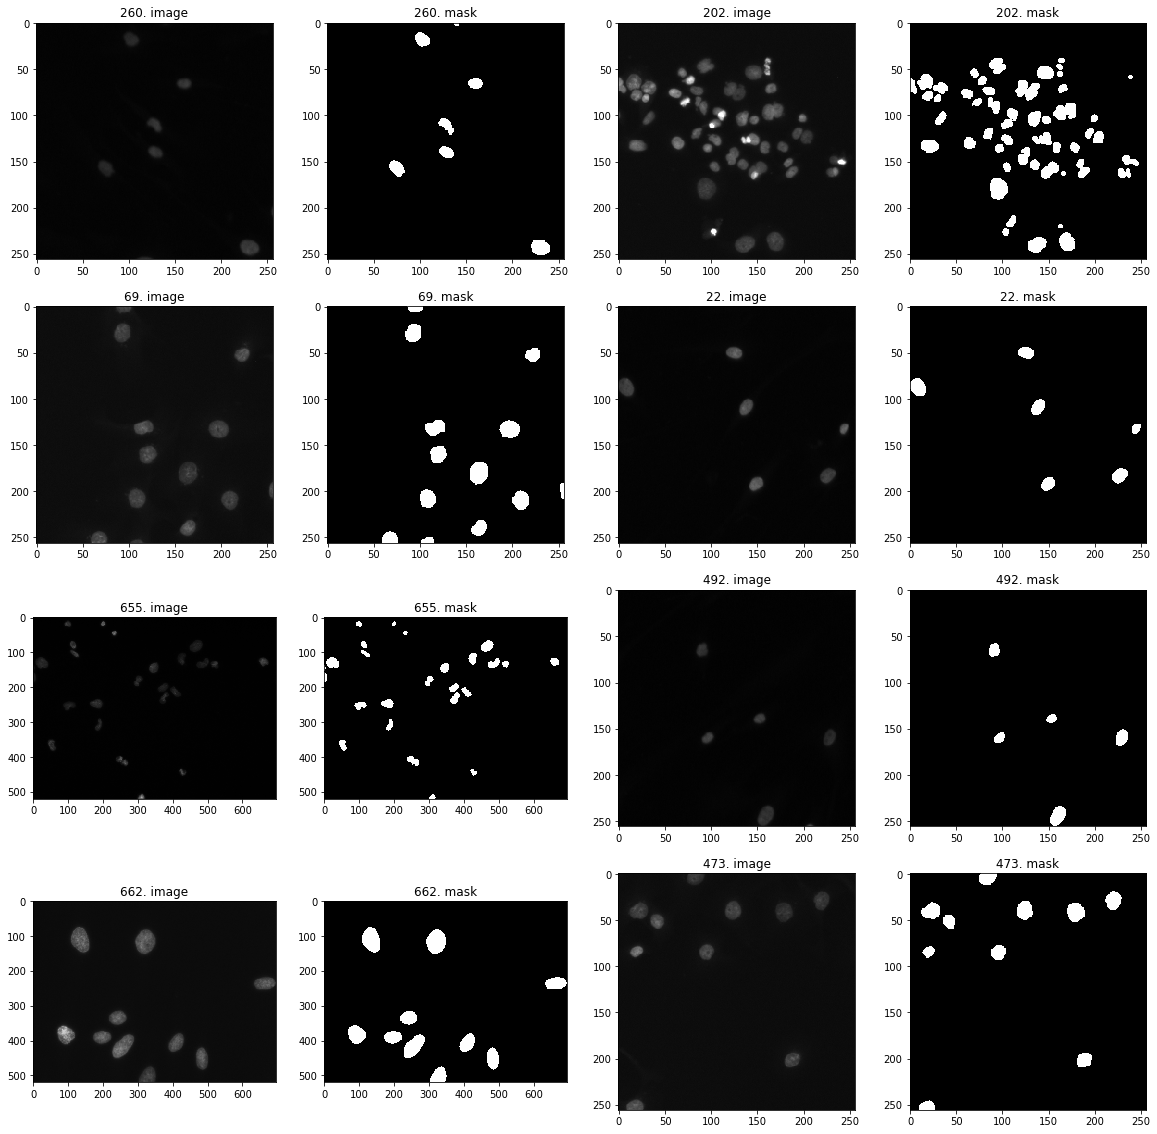

In [5]:
# Overview of train images/masks. There is a lot of variation concerning
# the form/size/number of nuclei and the darkness/lightness/colorfulness of 
# the images. 
fig, axs = plt.subplots(4,4,figsize=(20,20))
for i in range(4):
    for j in range(2):
        n = np.random.randint(0,len(train_df))
        axs[i,j*2].imshow(read_image(train_df['image_path'].loc[n]))
        axs[i,j*2].set_title('{}. image'.format(n))
        axs[i,j*2+1].imshow(read_mask(train_df['mask_dir'].loc[n]), cmap='gray') 
        axs[i,j*2+1].set_title('{}. mask'.format(n))       

In [6]:
# Read images/masks from files and resize them. Each image and mask 
# is stored as a 3-dim array where the number of channels is 3 and 1, respectively.
x_train, y_train, x_test = load_raw_data(train_df, test_df)

Loading and resizing train images and masks ...


100%|██████████| 670/670 [00:53<00:00, 23.11it/s]

Loading and resizing test images ...



100%|██████████| 65/65 [00:00<00:00, 261.18it/s]


x_train.shape: (670, 256, 256, 3) of dtype uint8
y_train.shape: (670, 256, 256, 1) of dtype uint8
x_test.shape: (65, 256, 256, 3) of dtype uint8


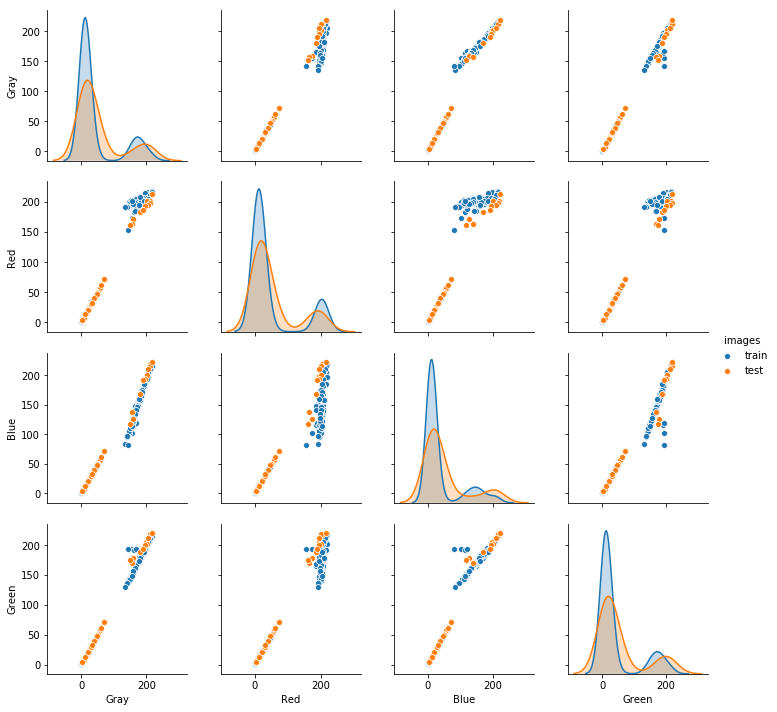

In [7]:
# Study the pixel intensity. On average the red, green and blue channels have similar
# intensities for all images. It should be noted that the background can be dark 
# (black) as  as well as light (white). 
def img_intensity_pairplot(x):
    """Plot intensity distributions of color channels."""
    df = pd.DataFrame()
    df['Gray'] = np.mean(x[:,:,:,:], axis=(1,2,3))
    if x.shape[3]==3:
        df['Red'] = np.mean(x[:,:,:,0], axis=(1,2))
        df['Blue'] = np.mean(x[:,:,:,1], axis=(1,2))
        df['Green'] = np.mean(x[:,:,:,2], axis=(1,2))
    return df

color_df = img_intensity_pairplot(np.concatenate([x_train, x_test]))
color_df['images'] = ['train']*len(x_train) + ['test']*len(x_test)
sns.pairplot(color_df, hue = 'images');

# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 

In [8]:
# Normalize all images and masks. There is the possibility to transform images 
# into the grayscale sepctrum and to invert images which have a very 
# light background.
x_train, y_train, x_test = preprocess_raw_data(x_train, y_train, x_test, invert=True)

Images normalized.
Images inverted to remove light backgrounds.


In [9]:
# Analyze nuclei sizes.
def get_nuclei_sizes():
    nuclei_sizes = []
    mask_idx = []
    for i in range(len(y_train)):
        mask = y_train[i].reshape(y_train.shape[1], y_train.shape[2])
        lab_mask = skimage.morphology.label(mask > .5)
        (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
        nuclei_sizes.extend(mask_sizes[1:])
        mask_idx.extend([i]*len(mask_sizes[1:]))
    return mask_idx, nuclei_sizes

mask_idx, nuclei_sizes = get_nuclei_sizes()
nuclei_sizes_df = pd.DataFrame()   
nuclei_sizes_df['mask_index'] = mask_idx
nuclei_sizes_df['nucleous_size'] = nuclei_sizes

print(nuclei_sizes_df.describe())
nuclei_sizes_df.sort_values(by='nucleous_size', ascending=True).head(10)

         mask_index  nucleous_size
count  23478.000000   23478.000000
mean     318.170074     260.183704
std      196.160204     430.462442
min        0.000000       1.000000
25%      144.000000      78.000000
50%      322.000000     132.000000
75%      497.000000     276.000000
max      669.000000   12064.000000


,mask_index,nucleous_size
14286,380,1
13663,361,1
9476,252,1
137,6,1
6389,152,1
13631,361,1
21605,604,1
18178,510,1
14237,380,1
277,6,1


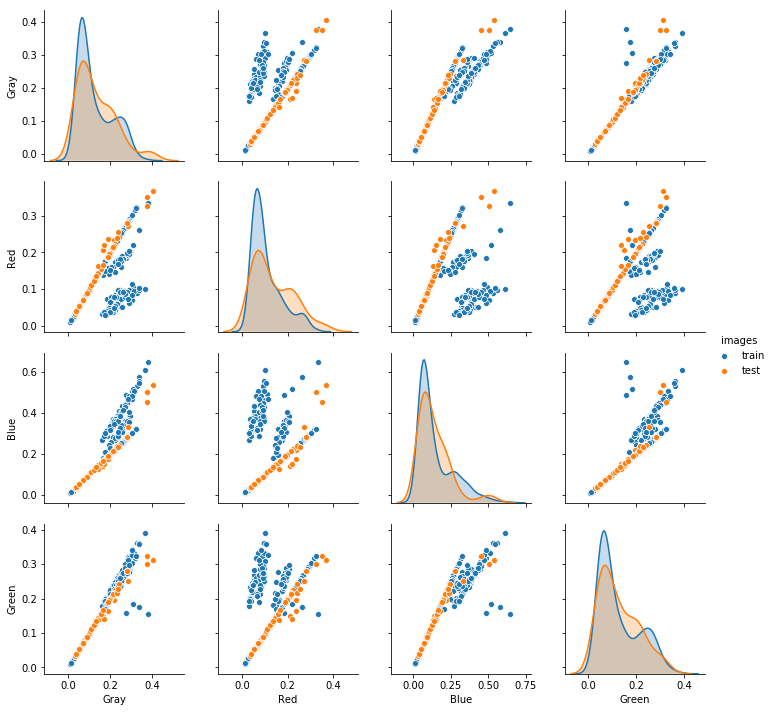

In [10]:
color_df = img_intensity_pairplot(np.concatenate([x_train, x_test]))
color_df['images'] = ['train']*len(x_train) + ['test']*len(x_test)
sns.pairplot(color_df, hue = 'images');

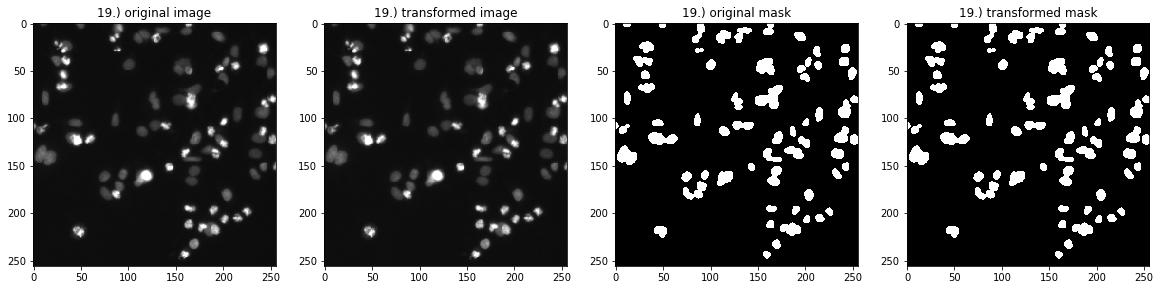

In [11]:
# Check the image transformation procedure (resizing, normalizing, inverting) 
# by looking at a sample. 
def img_comparison_plot(n):
    """Plot the original and transformed images/masks."""
    fig, axs = plt.subplots(1,4,figsize=(20,20))
    axs[0].imshow(read_image(train_df['image_path'].loc[n]))
    axs[0].set_title('{}.) original image'.format(n))
    img, img_type = imshow_args(x_train[n])
    axs[1].imshow(img, img_type)
    axs[1].set_title('{}.) transformed image'.format(n))
    axs[2].imshow(read_mask(train_df['mask_dir'].loc[n]), cm.gray) 
    axs[2].set_title('{}.) original mask'.format(n))
    axs[3].imshow(y_train[n,:,:,0], cm.gray)
    axs[3].set_title('{}.) transformed mask'.format(n));

n = 19 # np.random.randint(0, len(x_train))
img_comparison_plot(n)

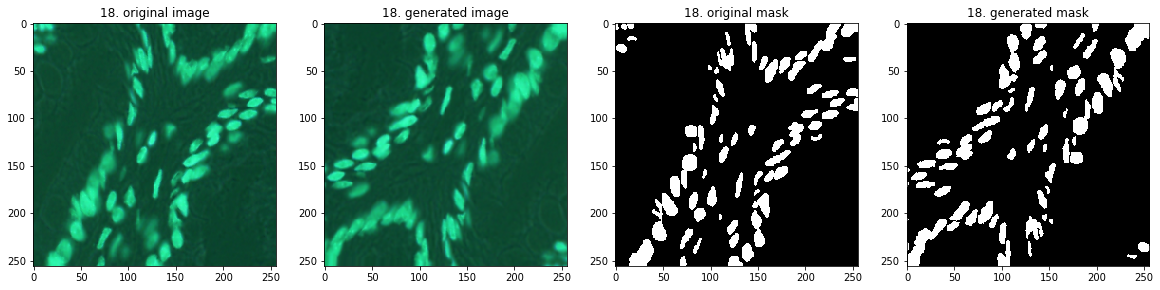

In [12]:
# Generate new images/masks via transformations applied on the original 
# images/maks. Data augmentations can be used for regularization.
def plot_generated_image_mask(n):
    fig, axs = plt.subplots(1,4,figsize=(20,20))
    img_new, mask_new = generate_images_and_masks(x_train[n:n+1], y_train[n:n+1])
    img, img_type = imshow_args(x_train[n])
    axs[0].imshow(img, img_type)
    axs[0].set_title('{}. original image'.format(n))
    img, img_type = imshow_args(img_new[0])
    axs[1].imshow(img, img_type)
    axs[1].set_title('{}. generated image'.format(n))
    axs[2].imshow(y_train[n,:,:,0], cmap='gray')
    axs[2].set_title('{}. original mask'.format(n))
    axs[3].imshow(mask_new[0,:,:,0], cmap='gray')
    axs[3].set_title('{}. generated mask'.format(n));

n = 18 # np.random.randint(len(x_train))
plot_generated_image_mask(n)

# 4. Score Metric <a class="anchor" id="4-bullet"></a> 

Final score: 0.016793788410886742
   threshold  precision   tp    fp    fn
0       0.50   0.093750  6.0  29.0  29.0
1       0.55   0.044776  3.0  32.0  32.0
2       0.60   0.029412  2.0  33.0  33.0
3       0.65   0.000000  0.0  35.0  35.0
4       0.70   0.000000  0.0  35.0  35.0
5       0.75   0.000000  0.0  35.0  35.0
6       0.80   0.000000  0.0  35.0  35.0
7       0.85   0.000000  0.0  35.0  35.0
8       0.90   0.000000  0.0  35.0  35.0
9       0.95   0.000000  0.0  35.0  35.0


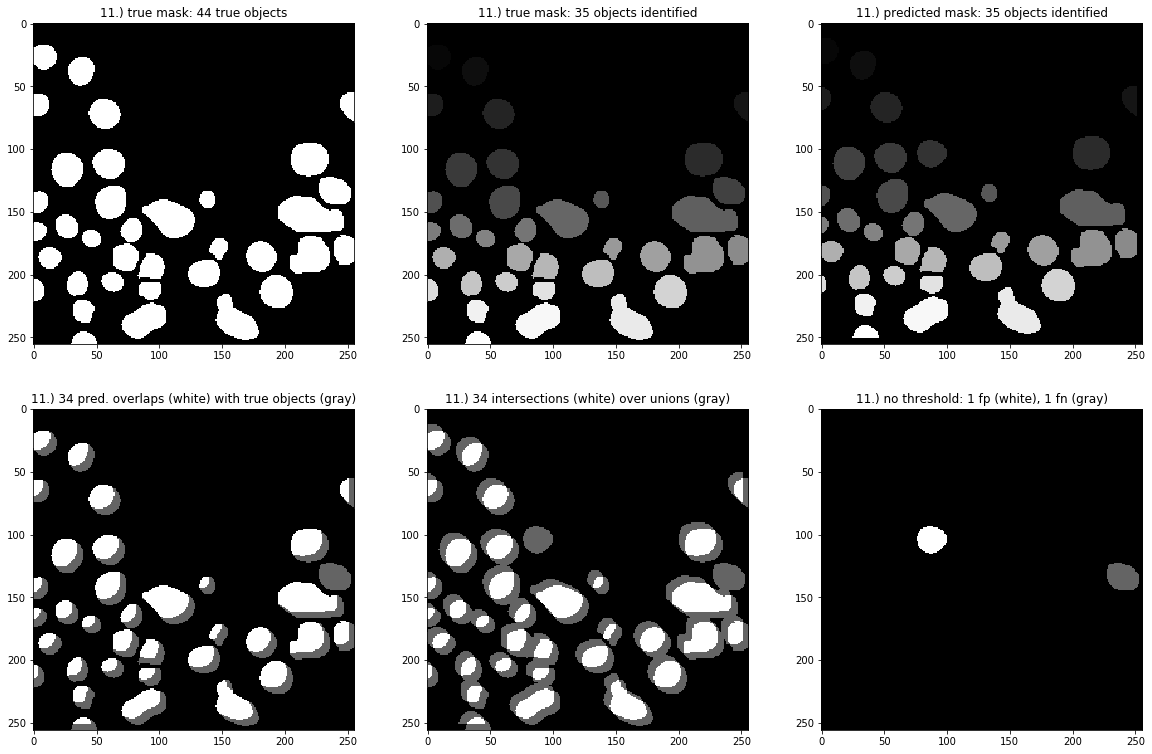

In [13]:
# Check the score metric for one sample. The predicted mask is simulated
# and can be modified in order to check the correct implementation of
# the score metric.
n = 11 # np.random.randint(len(x_train))
true_mask = y_train[n,:,:,0].copy()
lab_true_mask = get_labeled_mask(true_mask)
pred_mask = true_mask.copy() # Create predicted mask from true mask.
true_mask[lab_true_mask == 7] = 0 # Remove one object => false postive
pred_mask[lab_true_mask == 10] = 0 # Remove one object => false negative
offset = 5  # Offset.
pred_mask = pred_mask[offset:, offset:]
pred_mask = np.pad(pred_mask, ((0, offset), (0, offset)), mode="constant")
plot_score_summary(train_df, n, true_mask, pred_mask) 

In [14]:
# Study how many objects in the masks can be identified. This is a limiting factor
# for the overall performance.
min_pixels_per_object = 1
summary = []
for n in range(len(y_train)):
    img = y_train[n,:,:,0]
    lab_img=get_labeled_mask(img)
    img_labels, img_area = np.unique(lab_img, return_counts=True)
    img_labels = img_labels[img_area>=min_pixels_per_object]
    img_area = img_area[img_area>=min_pixels_per_object]
    n_true_labels = train_df['num_masks'][n]
    n_ident_labels = len(img_labels)
    diff = np.abs(n_ident_labels-n_true_labels)
    summary.append([n_true_labels, n_ident_labels, diff])

sum_df = pd.DataFrame(summary, columns=(['true_objects', 'identified_objects', 'subtraction']))
sum_df.describe()

,true_objects,identified_objects,subtraction
count,670.000000,670.000000,670.000000
mean,43.971642,36.041791,8.353731
std,47.962530,34.292874,17.335051
min,1.000000,2.000000,0.000000
25%,15.250000,14.250000,1.000000
50%,27.000000,24.000000,2.500000
75%,54.000000,44.000000,9.000000
max,375.000000,270.000000,173.000000


# 5. Train the Neural Network <a class="anchor" id="6-bullet"></a> 

In [15]:
# Create and start training of a new neural network, or continue training of
# a pretrained model.

#nn_name = ['nn0_256_256']  
#nn_name = ['nn0_384_384']  
#nn_name = ['nn0_512_512']  
nn_name = ['tmp'] # for testing purpose

# Implement cross validations
cv_num = 10 
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=SEED)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train)):

    # Start timer
    start = datetime.datetime.now();

    # Split into train and validation 
    x_trn = x_train[train_index]
    y_trn = y_train[train_index]
    x_vld = x_train[valid_index]
    y_vld = y_train[valid_index]
    
    # Choose a certain fold.
    if i==0:
        # Create and start training of a new model.
        if True:
            u_net = NeuralNetwork(nn_name=nn_name[0], log_step=0.1, input_shape=(256,256,3), 
                                  output_shape=(256,256,1)) # Create instance of neural network.
            u_net.build_graph() # Build graph.

            # Start tensorflow session.
            with tf.Session(graph=u_net.graph) as sess: 
                u_net.attach_saver() # Attach saver tensor.
                u_net.attach_summary(sess) # Attach summaries.
                sess.run(tf.global_variables_initializer()) # Variable initialization.

                # Training on original data.
                u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=1.0)

                for _ in range(2):
                    # Training on augmented data.
                    u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=.5,
                                      train_on_augmented_data=True)
                    u_net.save_model(sess) # Save parameters, tensors, summaries.

        # Continue training of a pretrained model.
        if False:
            u_net = NeuralNetwork() 
            sess = u_net.load_session_from_file(nn_name[0])  
            u_net.attach_saver() 
            u_net.attach_summary(sess) 

            # Training on original data.
            #u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=0.1) 

            for _ in range(1):
                # Training on augmented data.
                u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=.5,
                                  train_on_augmented_data = True)
                u_net.save_model(sess) # Save parameters, tensors, summaries.

print('Total running time: '.format(datetime.datetime.now() - start))

Build UNet Graph: 10 layers, 1766785 trainable weights
Training the Neural Network
	nn_name = tmp
	n_epoch = 1.0
	mb_size = 16
	learn_rate = 0.0010000000
	learn_rate_0 = 0.0010000000
	learn_rate_alpha = 0.2500000000
	learn_rate_step = 3
	learn_rate_pos = 0
	dropout_proba = 0.1
	input_shape = (256, 256, 3)
	output_shape = (256, 256, 1)
	x_train = (603, 256, 256, 3)
	x_valid = (67, 256, 256, 3)
	y_train = (603, 256, 256, 1)
	y_valid = (67, 256, 256, 1)
Training started: 06-11-2018 10:43:29
0.03 epoch: train/valid loss = 0.6483/0.6448 train/valid score = 0.0001/0.0001
0.13 epoch: train/valid loss = 0.3606/0.3400 train/valid score = 0.2017/0.1633
0.24 epoch: train/valid loss = 0.2527/0.2435 train/valid score = 0.2035/0.1801
0.34 epoch: train/valid loss = 0.1518/0.1584 train/valid score = 0.2940/0.2961
0.45 epoch: train/valid loss = 0.1820/0.1588 train/valid score = 0.2821/0.3186
0.56 epoch: train/valid loss = 0.1451/0.1446 train/valid score = 0.3605/0.3245
0.66 epoch: train/valid loss = 0.

In [16]:
# Start TensorBoard visualization. All summaries are written into the
# logs directory which is contained in the current working directory.
if False:
    !tensorboard --logdir=./logs

INFO:tensorflow:Restoring parameters from ./saves/tmp
Parameters of the loaded neural network
	nn_name = tmp
	epoch = 2.016583747927035
	mb_size = 16
	learn_rate = 0.0010000000
	learn_rate_0 = 0.0010000000
	learn_rate_alpha = 0.2500000000
	learn_rate_step = 3
	learn_rate_pos = 0
	dropout_proba = 0.1
	input_shape = (256, 256, 3)
	output_shape = (256, 256, 1)
final train/valid loss = 0.1133/0.1212
final train/valid score = 0.4020/0.3822


/home/raoul/Desktop/Data_Science_Bowl_2018/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/raoul/Desktop/Data_Science_Bowl_2018/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:3461: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


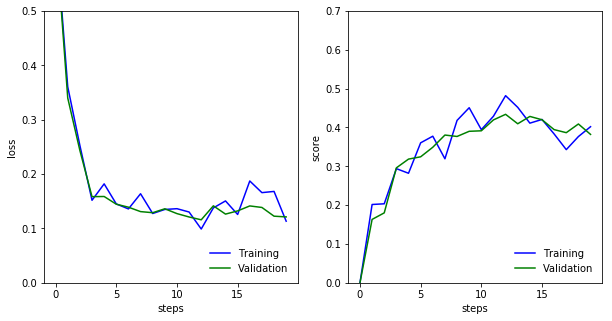

In [17]:
# Show intermediate losses and scores during the training session.
mn = 'tmp'
#mn = 'nn0_256_256'
#mn = 'nn8_384_384' 
#mn = 'nn0_512_512' 
#mn = 'nn1_256_256'

u_net = NeuralNetwork()
sess = u_net.load_session_from_file(mn)
sess.close()
train_loss = u_net.params['train_loss']
valid_loss = u_net.params['valid_loss']
train_score = u_net.params['train_score']
valid_score = u_net.params['valid_score']

print('final train/valid loss = {:.4f}/{:.4f}'.format(train_loss[-1], valid_loss[-1]))
print('final train/valid score = {:.4f}/{:.4f}'.format(train_score[-1], valid_score[-1]))
plt.figure(figsize=(10, 5));
plt.subplot(1,2,1)
plt.plot(np.arange(0,len(train_loss)), train_loss,'-b', label='Training')
plt.plot(np.arange(0,len(valid_loss)), valid_loss,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 0.5, ymin = 0.0)
plt.ylabel('loss')
plt.xlabel('steps');

plt.subplot(1,2,2);
plt.plot(np.arange(0,len(train_score)), train_score,'-b', label='Training')
plt.plot(np.arange(0,len(valid_score)), valid_score,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 0.7, ymin = 0.0)
plt.ylabel('score')
plt.xlabel('steps');

# 6. Validate the neural network <a class="anchor" id="7-bullet"></a> 

In [18]:
# Split training and validation data in the same way 
# as was done for training the neural network.
if True:
    cv_num = 10 
    kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=SEED)
    for i,(train_index, valid_index) in enumerate(kfold.split(x_train)):
        if i==0:
            x_trn = x_train[train_index]
            y_trn = y_train[train_index]
            x_vld = x_train[valid_index]
            y_vld = y_train[valid_index]

In [19]:
# Summary of scores for training and validations sets. Note that the score is
# better than the true score, since overlapping/touching nuclei can not be
# separately identified in this version.  
nn_name = ['tmp']
#nn_name = ['nn0_384_384','nn1_384_384','nn2_384_384','nn3_384_384','nn4_384_384',
#           'nn5_384_384','nn6_384_384','nn7_384_384','nn8_384_384','nn9_384_384']

# Overall score on train set.
if True:
    # Soft voting majority.
    for i,mn in enumerate(nn_name):
        u_net = NeuralNetwork()
        sess = u_net.load_session_from_file(mn)

        # Split data set due to memory constraints
        kfold = sklearn.model_selection.KFold(10, shuffle=False)
        for j,(_,idx) in enumerate(kfold.split(x_train)):
            if j==0: tmp = u_net.get_prediction(sess, x_train[idx])
            else: tmp = np.concatenate((tmp,u_net.get_prediction(sess, x_train[idx])), axis=0)

        if i==0: y_pred_proba = tmp
        else: y_pred_proba += tmp
        sess.close()
    y_pred_proba /= len(nn_name)  # normalize 
    y_pred = trsf_proba_to_binary(y_pred_proba)
    config.min_object_size = 100
    train_score = get_score(y_train, y_pred)
    tmp = np.concatenate([np.arange(len(x_train)).reshape(-1,1), train_score.reshape(-1,1)], axis=1)
    train_score_df = pd.DataFrame(tmp, columns=(['train_index','train_score']))
    print(train_score_df.describe())
    print('')
    print(train_score_df.sort_values(by='train_score', ascending=True).head())

# Overall score on validation set.
if False:
    # Soft voting majority.
    for i,mn in enumerate(nn_name):
        u_net = NeuralNetwork()
        sess = u_net.load_session_from_file(mn)
        if i==0: y_pred_proba = u_net.get_prediction(sess, x_vld)
        else: y_pred_proba += u_net.get_prediction(sess, x_vld)
        sess.close()
    y_pred_proba /= len(nn_name)  # normalize 

    y_pred = trsf_proba_to_binary(y_pred_proba)
    valid_score = get_score(y_vld, y_pred)
    tmp = np.concatenate([np.arange(len(valid_index)).reshape(-1,1),
                          valid_index.reshape(-1,1),
                          valid_score.reshape(-1,1)], axis=1)
    valid_score_df = pd.DataFrame(tmp, columns=(['index', 'valid_index','valid_score']))
    print('\n', valid_score_df.describe())
    print('\n', valid_score_df.sort_values(by='valid_score', ascending=True).head())

    # Plot the worst 4 predictions.
    fig, axs = plt.subplots(4,4,figsize=(20,20))
    list_ = valid_score_df.sort_values(by='valid_score', ascending=True)[:4]['index'].values.astype(np.int)
    #list_ = [valid_score_df['valid_score'].idxmin(),valid_score_df['valid_score'].idxmax()]
    for i,n in enumerate(list_):
        img, img_type = imshow_args(x_vld[n])
        axs[i,0].imshow(img, img_type)
        axs[i,0].set_title('{}.) input image'.format(n))
        axs[i,1].imshow(y_vld[n,:,:,0], cm.gray)
        axs[i,1].set_title('{}.) true mask'.format(n))
        axs[i,2].imshow(y_pred_proba[n,:,:,0], cmap='gray') 
        axs[i,2].set_title('{}.) predicted mask probabilities'.format(n))
        axs[i,3].imshow(y_pred[n,:,:,0], cmap='gray') 
        axs[i,3].set_title('{}.) predicted mask'.format(n));


INFO:tensorflow:Restoring parameters from ./saves/tmp
Parameters of the loaded neural network
	nn_name = tmp
	epoch = 2.016583747927035
	mb_size = 16
	learn_rate = 0.0010000000
	learn_rate_0 = 0.0010000000
	learn_rate_alpha = 0.2500000000
	learn_rate_step = 3
	learn_rate_pos = 0
	dropout_proba = 0.1
	input_shape = (256, 256, 3)
	output_shape = (256, 256, 1)
       train_index  train_score
count   670.000000   670.000000
mean    334.500000     0.447728
std     193.556624     0.253207
min       0.000000     0.000000
25%     167.250000     0.251021
50%     334.500000     0.443362
75%     501.750000     0.674114
max     669.000000     1.000000

     train_index  train_score
517        517.0          0.0
630        630.0          0.0
138        138.0          0.0
152        152.0          0.0
526        526.0          0.0


In [20]:
# Tune minimal object size for prediction 
if False:
    nn_name = ['tmp']
    #nn_name = ['nn0_384_384','nn1_384_384','nn2_384_384','nn3_384_384','nn4_384_384',
    #           'nn5_384_384','nn6_384_384','nn7_384_384','nn8_384_384','nn9_384_384']
    
    # Soft voting majority.
    for i,mn in enumerate(nn_name):
        u_net = NeuralNetwork()
        sess = u_net.load_session_from_file(mn)

        # Split data set due to memory constraints
        kfold = sklearn.model_selection.KFold(10, shuffle=False)
        for j,(_,idx) in enumerate(kfold.split(x_train)):
            if j==0: tmp = u_net.get_prediction(sess, x_train[idx])
            else: tmp = np.concatenate((tmp,u_net.get_prediction(sess, x_train[idx])), axis=0)

        if i==0: y_pred_proba = tmp
        else: y_pred_proba += tmp
        sess.close()
    y_pred_proba /= len(nn_name)  # normalize 
    y_pred = trsf_proba_to_binary(y_pred_proba)

    tmp = config.min_object_size
    min_object_sizes = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,200,300,400,500]
    for mos in min_object_sizes:
        config.min_object_size = mos
        valid_score = get_score(y_train, y_pred)
        print('config.min_object_size = {}: valid_score min/mean/std/max = {:.3f}/{:.3f}/{:.3f}/{:.3f}'.format(mos, 
                np.min(valid_score), np.mean(valid_score), np.std(valid_score), np.max(valid_score)))
    config.min_object_size = tmp

INFO:tensorflow:Restoring parameters from ./saves/tmp
Parameters of the loaded neural network
	nn_name = tmp
	epoch = 2.016583747927035
	mb_size = 16
	learn_rate = 0.0010000000
	learn_rate_0 = 0.0010000000
	learn_rate_alpha = 0.2500000000
	learn_rate_step = 3
	learn_rate_pos = 0
	dropout_proba = 0.1
	input_shape = (256, 256, 3)
	output_shape = (256, 256, 1)
Final score: 0.13167131844763424
   threshold  precision   tp    fp    fn
0       0.50   0.437500  7.0   5.0   4.0
1       0.55   0.277778  5.0   7.0   6.0
2       0.60   0.210526  4.0   8.0   7.0
3       0.65   0.150000  3.0   9.0   8.0
4       0.70   0.150000  3.0   9.0   8.0
5       0.75   0.045455  1.0  11.0  10.0
6       0.80   0.045455  1.0  11.0  10.0
7       0.85   0.000000  0.0  12.0  11.0
8       0.90   0.000000  0.0  12.0  11.0
9       0.95   0.000000  0.0  12.0  11.0


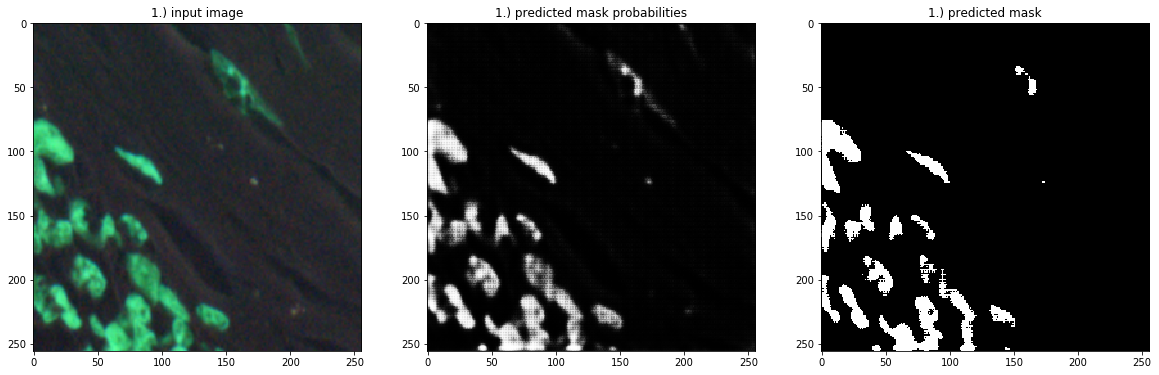

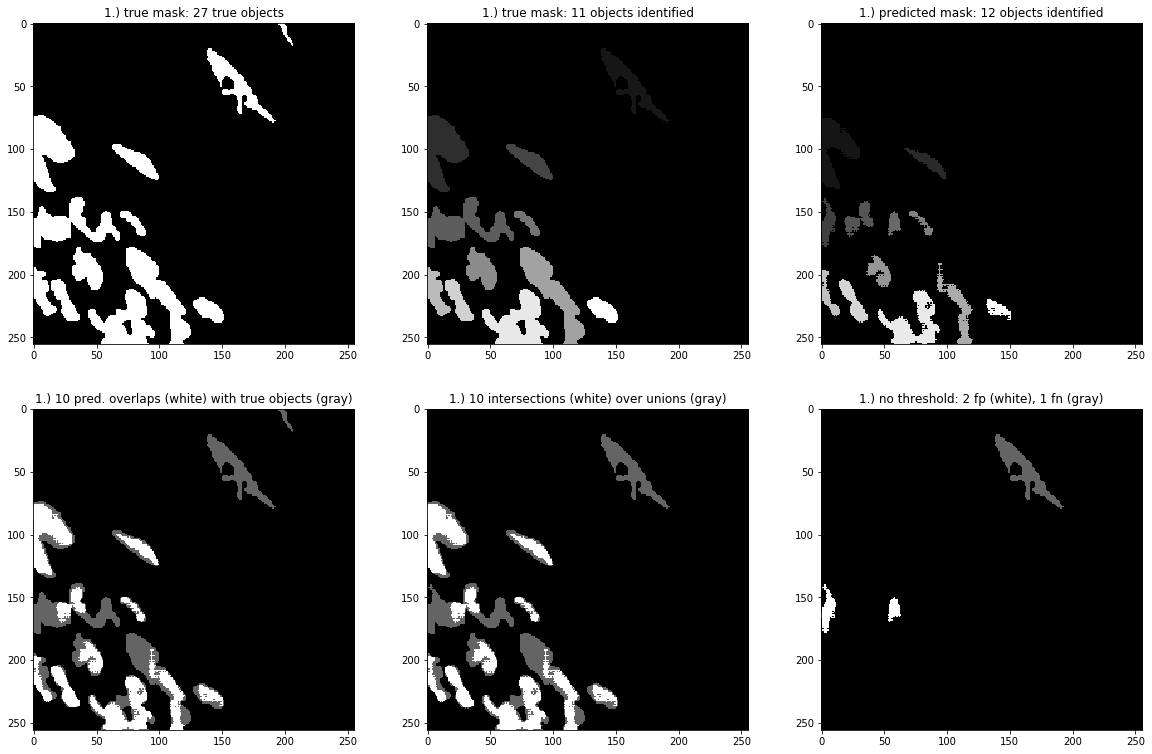

In [21]:
# Check one sample prediction in more detail.
#nn_name = ['nn0_384_384','nn1_384_384','nn2_384_384','nn3_384_384','nn4_384_384',
#           'nn5_384_384','nn6_384_384','nn7_384_384','nn8_384_384','nn9_384_384']
nn_name = ['tmp']

n = 1 # np.random.randint(len(x_train))
x_true = x_train[n]
y_true = y_train[n,:,:,0]

# Soft voting majority.
for i,mn in enumerate(nn_name):
    u_net = NeuralNetwork()
    sess = u_net.load_session_from_file(mn)
    
    if i==0: y_pred_proba = u_net.get_prediction(sess, np.expand_dims(x_true, axis=0))[0,:,:,0]
    else: y_pred_proba += u_net.get_prediction(sess, np.expand_dims(x_true, axis=0))[0,:,:,0]
    sess.close()

y_pred_proba /= len(nn_name)  # normalize                         
y_pred = trsf_proba_to_binary(y_pred_proba)

fig, axs = plt.subplots(1,3,figsize=(20,13))
img, img_type = imshow_args(x_true)
axs[0].imshow(img, img_type)
axs[0].set_title('{}.) input image'.format(n))
axs[1].imshow(y_pred_proba, cmap='gray') 
axs[1].set_title('{}.) predicted mask probabilities'.format(n));
axs[2].imshow(y_pred, cmap='gray') 
axs[2].set_title('{}.) predicted mask'.format(n));
plot_score_summary(train_df, n, y_true, y_pred)

# 7. Make Test Prediction <a class="anchor" id="8-bullet"></a> 

In [22]:
# Load neural network, make prediction for test masks, resize predicted
# masks to original image size and apply run length encoding for the
# submission file. 

# Load neural network and make prediction for masks.
#nn_name = ['nn0_512_512']
#nn_name = ['nn0_256_256']
#nn_name = ['nn0_256_256','nn1_256_256','nn2_256_256','nn3_256_256','nn4_256_256']
nn_name = ['tmp']
#nn_name = ['nn0_384_384','nn1_384_384','nn2_384_384','nn3_384_384','nn4_384_384',
#           'nn5_384_384','nn6_384_384','nn7_384_384','nn8_384_384','nn9_384_384']

# Soft voting majority.
for i,mn in enumerate(nn_name):
    u_net = NeuralNetwork()
    sess = u_net.load_session_from_file(mn)
    
    # Split test data set due to memory constraints
    kfold = sklearn.model_selection.KFold(20, shuffle=False)
    for j,(_,idx) in enumerate(kfold.split(x_test)):
        if j==0: tmp = u_net.get_prediction(sess, x_test[idx])
        else: tmp = np.concatenate((tmp, u_net.get_prediction(sess, x_test[idx])), axis=0)

    if i==0: y_test_pred_proba = tmp
    else: y_test_pred_proba += tmp
    sess.close()

y_test_pred_proba /= len(nn_name)  # normalize                         
y_test_pred = trsf_proba_to_binary(y_test_pred_proba)
print('y_test_pred.shape = {}'.format(y_test_pred.shape))

# Resize predicted masks to original image size.
y_test_pred_original_size = []
for i in range(len(y_test_pred)):
    res_mask = trsf_proba_to_binary(skimage.transform.resize(np.squeeze(y_test_pred[i]),
        (test_df.loc[i,'img_height'], test_df.loc[i,'img_width']), 
        mode='constant', preserve_range=True))
    y_test_pred_original_size.append(res_mask)
y_test_pred_original_size = np.array(y_test_pred_original_size)

print('y_test_pred_original_size.shape = {}'.format(y_test_pred_original_size.shape))
   
# Run length encoding of predicted test masks.
test_pred_rle = []
test_pred_ids = []
for n, id_ in enumerate(test_df['img_id']):
    config.min_object_size = 70*test_df.loc[n,'img_height']*test_df.loc[n,'img_width']/(384*384)
    rle = list(mask_to_rle(y_test_pred_original_size[n]))
    test_pred_rle.extend(rle)
    test_pred_ids.extend([id_]*len(rle))

print('test_pred_ids.shape = {}'.format(np.array(test_pred_ids).shape))
print('test_pred_rle.shape = {}'.format(np.array(test_pred_rle).shape))

INFO:tensorflow:Restoring parameters from ./saves/tmp
Parameters of the loaded neural network
	nn_name = tmp
	epoch = 2.016583747927035
	mb_size = 16
	learn_rate = 0.0010000000
	learn_rate_0 = 0.0010000000
	learn_rate_alpha = 0.2500000000
	learn_rate_step = 3
	learn_rate_pos = 0
	dropout_proba = 0.1
	input_shape = (256, 256, 3)
	output_shape = (256, 256, 1)
y_test_pred.shape = (65, 256, 256, 1)


/home/raoul/Desktop/Data_Science_Bowl_2018/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


y_test_pred_original_size.shape = (65,)
test_pred_ids.shape = (3488,)
test_pred_rle.shape = (3488,)


Run length encoding: 180960 matches, 0 misses


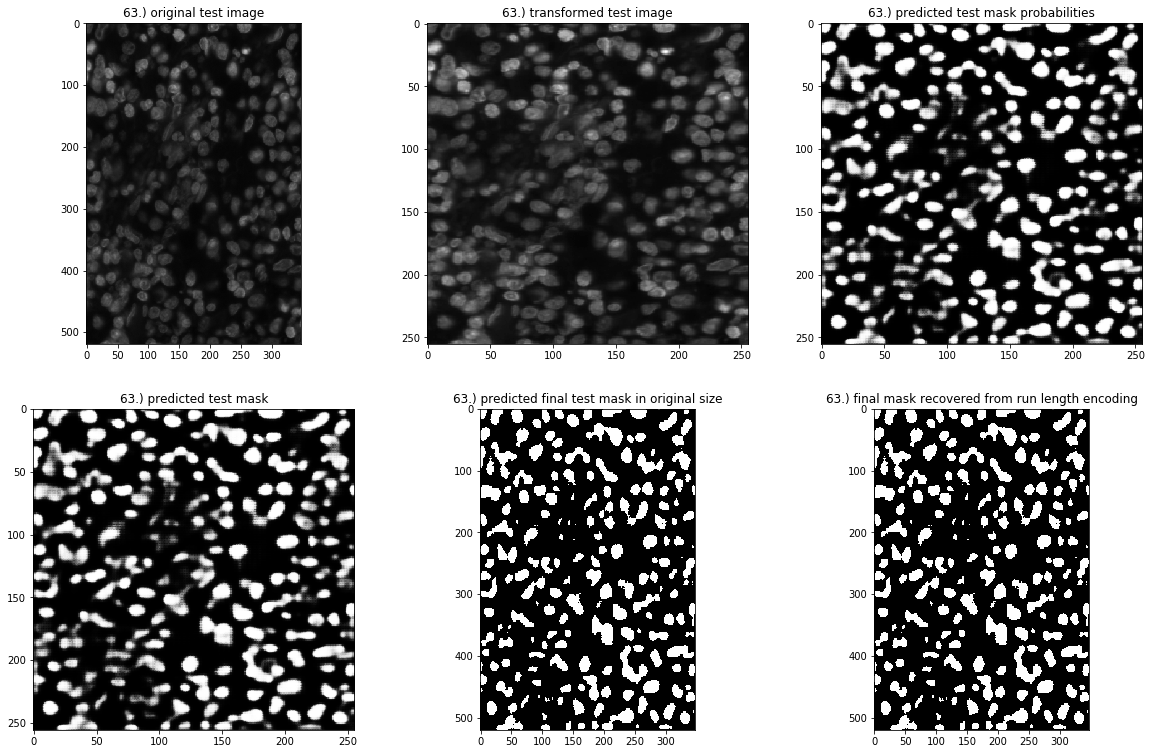

In [23]:
# Inspect a test prediction and check run length encoding.
n = 63 # np.random.randint(len(x_test))
mask = y_test_pred_original_size[n]
rle = list(mask_to_rle(mask))
mask_rec = rle_to_mask(rle, mask.shape)
print('Run length encoding: {} matches, {} misses'.format(
    (mask_rec == mask).sum(),(mask_rec != mask).sum()))

fig, axs = plt.subplots(2,3,figsize=(20,13))
axs[0,0].imshow(read_image(test_df['image_path'].loc[n]))
axs[0,0].set_title('{}.) original test image'.format(n))
img, img_type = imshow_args(x_test[n])
axs[0,1].imshow(img, img_type)
axs[0,1].set_title('{}.) transformed test image'.format(n))
axs[0,2].imshow(y_test_pred_proba[n][:,:,0], cm.gray) 
axs[0,2].set_title('{}.) predicted test mask probabilities'.format(n));
axs[1,0].imshow(y_test_pred_proba[n][:,:,0], cm.gray) 
axs[1,0].set_title('{}.) predicted test mask'.format(n));
axs[1,1].imshow(y_test_pred_original_size[n], cm.gray);
axs[1,1].set_title('{}.) predicted final test mask in original size'.format(n));
axs[1,2].imshow(mask_rec[:,:], cm.gray);
axs[1,2].set_title('{}.) final mask recovered from run length encoding'.format(n));

# 8. Submit <a class="anchor" id="9-bullet"></a> 

In [24]:
# Create submission file
sub = pd.DataFrame()
sub['ImageId'] = test_pred_ids
sub['EncodedPixels'] = pd.Series(test_pred_rle).apply(lambda x: ' '.join(str(y) for y in x))
#sub.groupby('ImageId').ngroup()
sub.to_csv('sub-dsbowl2018.csv', index=False)
sub.head()

,ImageId,EncodedPixels
0,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,57350 7 57604 10 57859 11 58114 13 58370 13 58...
1,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,33039 4 33294 7 33549 10 33805 10 34060 12 343...
2,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,25656 3 25910 7 26165 9 26421 10 26677 10 2693...
3,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,29036 7 29290 11 29546 13 29802 14 30058 15 30...
4,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,62064 7 62317 12 62572 14 62827 16 63082 17 63...
